In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import torch
import torchvision.transforms as transforms
import ast
from tqdm import tqdm
import sklearn
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import os


In [ ]:
class MoviePosterDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, genre_to_idx=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Convert stringified lists to actual lists
        self.data['genres'] = self.data['genres'].apply(ast.literal_eval)

        # Build genre index mapping if not provided
        self.all_genres = sorted(set(g for genre_list in self.data['genres'] for g in genre_list))
        self.genre_to_idx = genre_to_idx or {genre: idx for idx, genre in enumerate(self.all_genres)}

    def __len__(self):
        return len(self.data)

    def get_genre_idx(self):
        return self.genre_to_idx

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        movie_id = row['movie_id']
        genres = row['genres']

        # Multi-hot encode the genres
        label = torch.zeros(len(self.genre_to_idx))
        for genre in genres:
            if genre in self.genre_to_idx:
                label[self.genre_to_idx[genre]] = 1.0

        # Load image
        img_path = os.path.join(self.image_dir, f"{movie_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((200,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

csv_file = "movies_with_posters.csv"
image_dir = "../posters"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = MoviePosterDataset(csv_file, image_dir, transform)
genre_to_idx = dataset.get_genre_idx()

total_size = len(dataset)
indices = list(range(total_size))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.7, random_state=42)

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

def preload_to_gpu(subset, device):
    imgs, labels = [], []
    for img, label in tqdm(subset, desc="Preloading to GPU"):
        imgs.append(img.unsqueeze(0))
        labels.append(label.unsqueeze(0))
    imgs = torch.cat(imgs).to(device)
    labels = torch.cat(labels).to(device)
    print(imgs.device)    # Should be: cuda:0
    print(labels.device)
    return TensorDataset(imgs, labels)

train_tensor_dataset = preload_to_gpu(train_set, device)
val_tensor_dataset = preload_to_gpu(val_set, device)
# test_tensor_dataset = preload_to_gpu(test_set, device)

Preloading to GPU: 100%|██████████| 16919/16919 [02:37<00:00, 107.74it/s]


cuda:0
cuda:0


Preloading to GPU: 100%|██████████| 2175/2175 [00:19<00:00, 110.58it/s]


cuda:0
cuda:0


In [ ]:
df = pd.read_csv(csv_file)
for i in range(0, 7):
    print(f"{df['movie_id'][i]}, {df['genres'][i]}, {dataset[i][1].numpy()}")

In [3]:
genre_to_idx

{'Action': 0,
 'Adventure': 1,
 'Comedy': 2,
 'Crime': 3,
 'Drama': 4,
 'Horror': 5,
 'Romance': 6,
 'Sci-Fi': 7,
 'Thriller': 8}

In [4]:


# Dataloaders from preloaded tensors (no pin_memory needed)
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_tensor_dataset, batch_size=16, shuffle=False)


In [26]:
test_tensor_dataset = preload_to_gpu(test_set, device)
test_loader = DataLoader(test_tensor_dataset, batch_size=16, shuffle=False)

Preloading to GPU: 100%|██████████| 5077/5077 [00:47<00:00, 107.64it/s]


cuda:0
cuda:0


In [5]:
import matplotlib.pyplot as plt

def visualize_posters(dataset, genre_to_idx, num_images=9):
    idx_to_genre = {v: k for k, v in genre_to_idx.items()}
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        image, label = dataset[i]

        # Get genre names from the multi-hot encoded label
        genres = [idx_to_genre[idx] for idx, val in enumerate(label) if val == 1]

        # Plotting
        plt.subplot(int(num_images ** 0.5) + 1, int(num_images ** 0.5) + 1, i + 1)
        img = image.permute(1, 2, 0) * 0.5 + 0.5  # unnormalize from [-1, 1] to [0, 1]
        plt.imshow(img)
        plt.title(", ".join(genres), fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def plot_training_curves(train_acc, val_acc, train_loss, val_loss, epochs=None):

    if epochs is None:
        epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

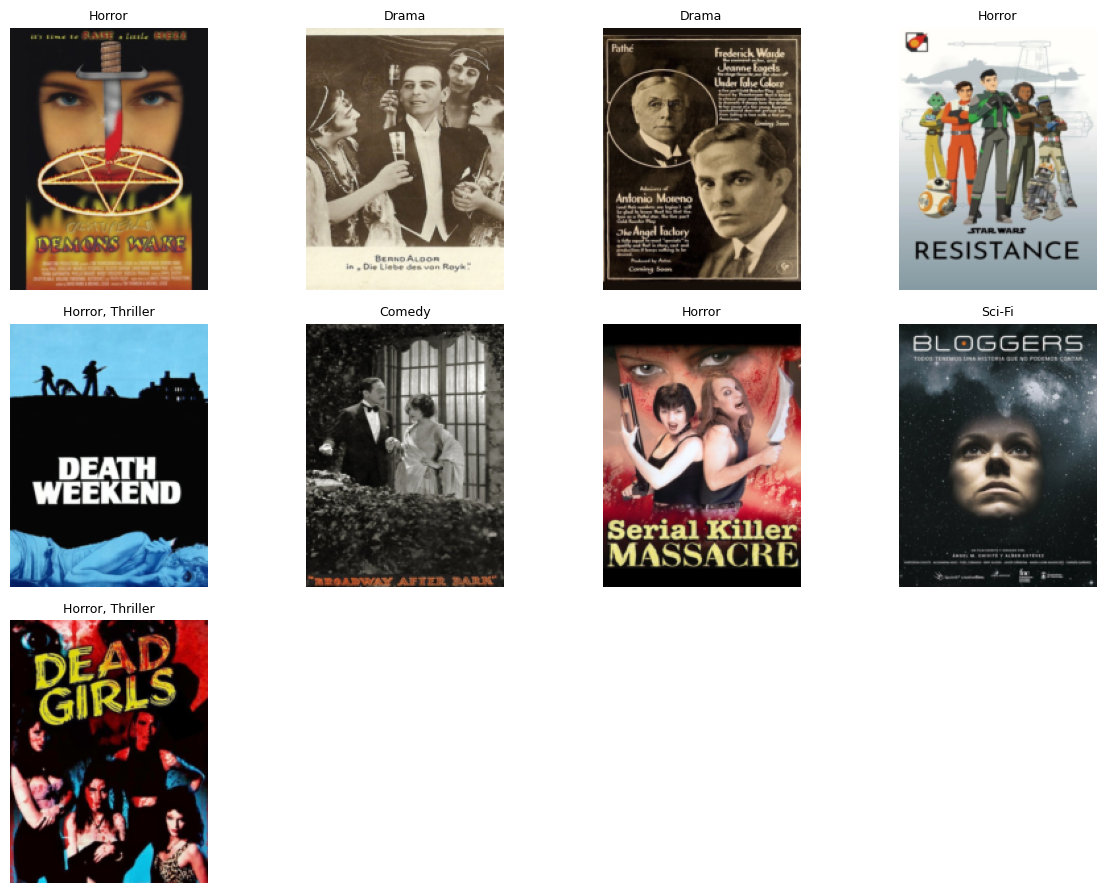

In [6]:
visualize_posters(train_set, dataset.genre_to_idx)

In [ ]:

def get_model(num_classes):
    model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

    for param in model.parameters():
        param.requires_grad = False
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )

    return model

def compute_metrics(outputs, targets, threshold=0.5):
    outputs = torch.sigmoid(outputs).detach().cpu().numpy()
    targets = targets.cpu().numpy()
    preds = (outputs >= threshold).astype(int)

    f1 = f1_score(targets, preds, average='macro', zero_division=0)
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    recall = recall_score(targets, preds, average='macro', zero_division=0)
    acc = accuracy_score(targets, preds)
    return acc, f1, precision, recall

def train_model(model, train_loader, val_loader, device, num_epochs=30, save_path='best_model.pth'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam( model.parameters(), lr=1e-2)
    b0_train_acc = []
    b0_train_loss =[]
    b0_val_acc =[]
    b0_val_loss=[]
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_outputs = []
        all_targets = []

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for images, labels in loop:
            # images = images.to(device, non_blocking=True)
            # labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(labels)
            loop.set_postfix(loss=loss.item())

        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)
        train_acc, train_f1, train_prec, train_rec = compute_metrics(all_outputs, all_targets)
        b0_train_acc.append(train_acc)
        b0_train_loss.append(running_loss / len(train_loader))
        print(f"\n[Train Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f} | "
              f"Acc: {train_acc:.4f} | F1: {train_f1:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f}")

        model.eval()
        val_outputs = []
        val_targets = []
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                # images = images.to(device)
                # labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_outputs.append(outputs)
                val_targets.append(labels)

        val_outputs = torch.cat(val_outputs)
        val_targets = torch.cat(val_targets)
        val_acc, val_f1, val_prec, val_rec = compute_metrics(val_outputs, val_targets)
        b0_val_acc.append(val_acc)
        b0_val_loss.append(val_loss / len(val_loader))
        print(f"\n[Validation Epoch {epoch+1}] Loss: {val_loss / len(val_loader):.4f} | "
              f"Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with improved F1: {val_f1:.4f}")

    return b0_train_acc, b0_train_loss, b0_val_acc,  b0_val_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


num_classes = len(dataset.genre_to_idx)

model = get_model(num_classes).to(device)

train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, device, num_epochs=30, save_path="efficientnet_b0_best.pth")


Using device: cuda


Epoch [1/30]: 100%|██████████| 529/529 [00:09<00:00, 55.67it/s, loss=0.426]



[Train Epoch 1] Loss: 0.4935 | Acc: 0.0958 | F1: 0.2682 | Precision: 0.3437 | Recall: 0.2216

[Validation Epoch 1] Loss: 0.4538 | Acc: 0.1177 | F1: 0.3009 | Precision: 0.4180 | Recall: 0.2570
Model saved with improved F1: 0.3009


Epoch [2/30]: 100%|██████████| 529/529 [00:09<00:00, 56.49it/s, loss=0.467]



[Train Epoch 2] Loss: 0.4953 | Acc: 0.1044 | F1: 0.2855 | Precision: 0.3630 | Recall: 0.2370

[Validation Epoch 2] Loss: 0.4637 | Acc: 0.1099 | F1: 0.2507 | Precision: 0.4277 | Recall: 0.2134


Epoch [3/30]: 100%|██████████| 529/529 [00:09<00:00, 55.71it/s, loss=0.488]



[Train Epoch 3] Loss: 0.4940 | Acc: 0.1088 | F1: 0.2795 | Precision: 0.3623 | Recall: 0.2294

[Validation Epoch 3] Loss: 0.4517 | Acc: 0.1237 | F1: 0.2833 | Precision: 0.4268 | Recall: 0.2413


Epoch [4/30]: 100%|██████████| 529/529 [00:09<00:00, 55.24it/s, loss=0.421]



[Train Epoch 4] Loss: 0.4946 | Acc: 0.1053 | F1: 0.2818 | Precision: 0.3657 | Recall: 0.2311

[Validation Epoch 4] Loss: 0.4455 | Acc: 0.1182 | F1: 0.2480 | Precision: 0.4549 | Recall: 0.1843


Epoch [5/30]: 100%|██████████| 529/529 [00:09<00:00, 53.77it/s, loss=0.537]



[Train Epoch 5] Loss: 0.4926 | Acc: 0.1086 | F1: 0.2812 | Precision: 0.3665 | Recall: 0.2300

[Validation Epoch 5] Loss: 0.4472 | Acc: 0.1145 | F1: 0.2937 | Precision: 0.4309 | Recall: 0.2378


Epoch [6/30]: 100%|██████████| 529/529 [00:09<00:00, 55.04it/s, loss=0.522]



[Train Epoch 6] Loss: 0.4953 | Acc: 0.1062 | F1: 0.2828 | Precision: 0.3685 | Recall: 0.2312

[Validation Epoch 6] Loss: 0.4615 | Acc: 0.1223 | F1: 0.2562 | Precision: 0.4354 | Recall: 0.2187


Epoch [7/30]: 100%|██████████| 529/529 [00:09<00:00, 54.85it/s, loss=0.563]



[Train Epoch 7] Loss: 0.4923 | Acc: 0.1062 | F1: 0.2803 | Precision: 0.3655 | Recall: 0.2291

[Validation Epoch 7] Loss: 0.4430 | Acc: 0.1094 | F1: 0.2577 | Precision: 0.4215 | Recall: 0.1964


Epoch [8/30]: 100%|██████████| 529/529 [00:09<00:00, 55.96it/s, loss=0.428]



[Train Epoch 8] Loss: 0.4954 | Acc: 0.1089 | F1: 0.2828 | Precision: 0.3702 | Recall: 0.2305

[Validation Epoch 8] Loss: 0.4617 | Acc: 0.1145 | F1: 0.2333 | Precision: 0.4896 | Recall: 0.1803


Epoch [9/30]: 100%|██████████| 529/529 [00:09<00:00, 57.25it/s, loss=0.548]



[Train Epoch 9] Loss: 0.4936 | Acc: 0.1092 | F1: 0.2806 | Precision: 0.3682 | Recall: 0.2290

[Validation Epoch 9] Loss: 0.4479 | Acc: 0.1094 | F1: 0.2762 | Precision: 0.4327 | Recall: 0.2117


Epoch [10/30]: 100%|██████████| 529/529 [00:09<00:00, 57.41it/s, loss=0.486]



[Train Epoch 10] Loss: 0.4957 | Acc: 0.1073 | F1: 0.2788 | Precision: 0.3645 | Recall: 0.2278

[Validation Epoch 10] Loss: 0.4562 | Acc: 0.1090 | F1: 0.2927 | Precision: 0.4360 | Recall: 0.2392


Epoch [11/30]: 100%|██████████| 529/529 [00:09<00:00, 57.02it/s, loss=0.598]



[Train Epoch 11] Loss: 0.4930 | Acc: 0.1052 | F1: 0.2747 | Precision: 0.3600 | Recall: 0.2238

[Validation Epoch 11] Loss: 0.4475 | Acc: 0.1195 | F1: 0.2889 | Precision: 0.4299 | Recall: 0.2233


Epoch [12/30]: 100%|██████████| 529/529 [00:09<00:00, 56.63it/s, loss=0.43] 



[Train Epoch 12] Loss: 0.4960 | Acc: 0.1086 | F1: 0.2776 | Precision: 0.3624 | Recall: 0.2265

[Validation Epoch 12] Loss: 0.4554 | Acc: 0.0901 | F1: 0.2292 | Precision: 0.4292 | Recall: 0.1636


Epoch [13/30]: 100%|██████████| 529/529 [00:09<00:00, 56.34it/s, loss=0.405]



[Train Epoch 13] Loss: 0.4961 | Acc: 0.1088 | F1: 0.2808 | Precision: 0.3667 | Recall: 0.2293

[Validation Epoch 13] Loss: 0.4464 | Acc: 0.1320 | F1: 0.2943 | Precision: 0.4362 | Recall: 0.2332


Epoch [14/30]: 100%|██████████| 529/529 [00:09<00:00, 56.13it/s, loss=0.462]



[Train Epoch 14] Loss: 0.4940 | Acc: 0.1097 | F1: 0.2822 | Precision: 0.3691 | Recall: 0.2305

[Validation Epoch 14] Loss: 0.4444 | Acc: 0.1030 | F1: 0.2534 | Precision: 0.4341 | Recall: 0.1864


Epoch [15/30]: 100%|██████████| 529/529 [00:09<00:00, 55.51it/s, loss=0.409]



[Train Epoch 15] Loss: 0.4931 | Acc: 0.1065 | F1: 0.2804 | Precision: 0.3680 | Recall: 0.2284

[Validation Epoch 15] Loss: 0.4489 | Acc: 0.1228 | F1: 0.2593 | Precision: 0.4715 | Recall: 0.1848


Epoch [16/30]: 100%|██████████| 529/529 [00:09<00:00, 56.14it/s, loss=0.552]



[Train Epoch 16] Loss: 0.4963 | Acc: 0.1072 | F1: 0.2794 | Precision: 0.3663 | Recall: 0.2276

[Validation Epoch 16] Loss: 0.4488 | Acc: 0.1223 | F1: 0.2625 | Precision: 0.4253 | Recall: 0.2151


Epoch [17/30]: 100%|██████████| 529/529 [00:09<00:00, 54.96it/s, loss=0.512]



[Train Epoch 17] Loss: 0.4926 | Acc: 0.1046 | F1: 0.2810 | Precision: 0.3668 | Recall: 0.2298

[Validation Epoch 17] Loss: 0.4503 | Acc: 0.1177 | F1: 0.2503 | Precision: 0.4325 | Recall: 0.1900


Epoch [18/30]: 100%|██████████| 529/529 [00:09<00:00, 54.93it/s, loss=0.465]



[Train Epoch 18] Loss: 0.4947 | Acc: 0.1079 | F1: 0.2785 | Precision: 0.3653 | Recall: 0.2271

[Validation Epoch 18] Loss: 0.4345 | Acc: 0.1416 | F1: 0.2698 | Precision: 0.4624 | Recall: 0.1986


Epoch [19/30]: 100%|██████████| 529/529 [00:09<00:00, 56.27it/s, loss=0.533]



[Train Epoch 19] Loss: 0.4955 | Acc: 0.1068 | F1: 0.2764 | Precision: 0.3617 | Recall: 0.2255

[Validation Epoch 19] Loss: 0.4582 | Acc: 0.1131 | F1: 0.2803 | Precision: 0.4199 | Recall: 0.2338


Epoch [20/30]: 100%|██████████| 529/529 [00:09<00:00, 55.30it/s, loss=0.453]



[Train Epoch 20] Loss: 0.4923 | Acc: 0.1102 | F1: 0.2828 | Precision: 0.3706 | Recall: 0.2306

[Validation Epoch 20] Loss: 0.4412 | Acc: 0.1099 | F1: 0.2496 | Precision: 0.4303 | Recall: 0.1912


Epoch [21/30]: 100%|██████████| 529/529 [00:09<00:00, 56.31it/s, loss=0.52] 



[Train Epoch 21] Loss: 0.4938 | Acc: 0.1095 | F1: 0.2830 | Precision: 0.3715 | Recall: 0.2305

[Validation Epoch 21] Loss: 0.4573 | Acc: 0.1011 | F1: 0.2806 | Precision: 0.4399 | Recall: 0.2294


Epoch [22/30]: 100%|██████████| 529/529 [00:09<00:00, 55.36it/s, loss=0.481]



[Train Epoch 22] Loss: 0.4938 | Acc: 0.1092 | F1: 0.2827 | Precision: 0.3690 | Recall: 0.2311

[Validation Epoch 22] Loss: 0.4655 | Acc: 0.1039 | F1: 0.2739 | Precision: 0.4039 | Recall: 0.2319


Epoch [23/30]: 100%|██████████| 529/529 [00:09<00:00, 55.28it/s, loss=0.411]



[Train Epoch 23] Loss: 0.4934 | Acc: 0.1102 | F1: 0.2813 | Precision: 0.3694 | Recall: 0.2290

[Validation Epoch 23] Loss: 0.4478 | Acc: 0.1122 | F1: 0.2803 | Precision: 0.4393 | Recall: 0.2220


Epoch [24/30]: 100%|██████████| 529/529 [00:09<00:00, 54.31it/s, loss=0.571]



[Train Epoch 24] Loss: 0.4953 | Acc: 0.1082 | F1: 0.2789 | Precision: 0.3646 | Recall: 0.2273

[Validation Epoch 24] Loss: 0.4481 | Acc: 0.1131 | F1: 0.2687 | Precision: 0.4540 | Recall: 0.2107


Epoch [25/30]: 100%|██████████| 529/529 [00:10<00:00, 52.54it/s, loss=0.493]



[Train Epoch 25] Loss: 0.4937 | Acc: 0.1073 | F1: 0.2802 | Precision: 0.3669 | Recall: 0.2284

[Validation Epoch 25] Loss: 0.4530 | Acc: 0.1347 | F1: 0.2783 | Precision: 0.4469 | Recall: 0.2205


Epoch [26/30]: 100%|██████████| 529/529 [00:09<00:00, 56.37it/s, loss=0.402]



[Train Epoch 26] Loss: 0.4939 | Acc: 0.1070 | F1: 0.2817 | Precision: 0.3684 | Recall: 0.2297

[Validation Epoch 26] Loss: 0.4504 | Acc: 0.1214 | F1: 0.2653 | Precision: 0.4444 | Recall: 0.2043


Epoch [27/30]: 100%|██████████| 529/529 [00:09<00:00, 54.68it/s, loss=0.419]



[Train Epoch 27] Loss: 0.4918 | Acc: 0.1056 | F1: 0.2829 | Precision: 0.3687 | Recall: 0.2315

[Validation Epoch 27] Loss: 0.4492 | Acc: 0.1030 | F1: 0.2539 | Precision: 0.4320 | Recall: 0.1887


Epoch [28/30]: 100%|██████████| 529/529 [00:09<00:00, 54.24it/s, loss=0.485]



[Train Epoch 28] Loss: 0.4940 | Acc: 0.1034 | F1: 0.2792 | Precision: 0.3648 | Recall: 0.2278

[Validation Epoch 28] Loss: 0.4598 | Acc: 0.1186 | F1: 0.2480 | Precision: 0.4473 | Recall: 0.2033


Epoch [29/30]: 100%|██████████| 529/529 [00:10<00:00, 52.09it/s, loss=0.485]



[Train Epoch 29] Loss: 0.4947 | Acc: 0.1049 | F1: 0.2756 | Precision: 0.3626 | Recall: 0.2241

[Validation Epoch 29] Loss: 0.4485 | Acc: 0.0924 | F1: 0.2741 | Precision: 0.4475 | Recall: 0.2100


Epoch [30/30]: 100%|██████████| 529/529 [00:09<00:00, 54.01it/s, loss=0.436]



[Train Epoch 30] Loss: 0.4949 | Acc: 0.1098 | F1: 0.2812 | Precision: 0.3675 | Recall: 0.2296

[Validation Epoch 30] Loss: 0.4459 | Acc: 0.1301 | F1: 0.2635 | Precision: 0.4659 | Recall: 0.1988


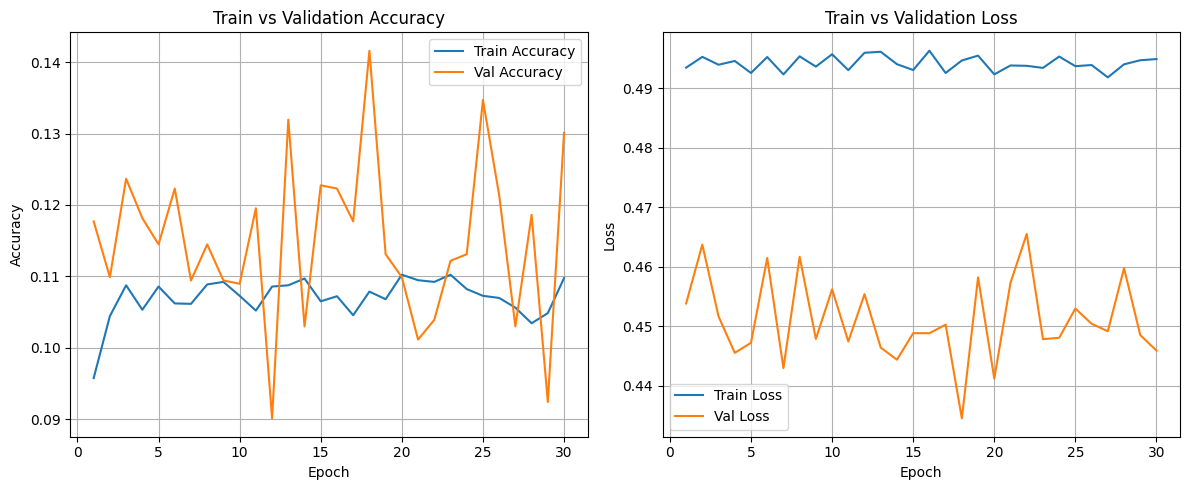

In [9]:
plot_training_curves(train_acc, val_acc, train_loss, val_loss)

In [11]:

def get_model(num_classes):
    model = models.efficientnet_b2(weights="EfficientNet_B2_Weights.DEFAULT")

    for param in model.parameters():
        param.requires_grad = False
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )

    return model

def compute_metrics(outputs, targets, threshold=0.5):
    outputs = torch.sigmoid(outputs).detach().cpu().numpy()
    targets = targets.cpu().numpy()
    preds = (outputs >= threshold).astype(int)

    f1 = f1_score(targets, preds, average='macro', zero_division=0)
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    recall = recall_score(targets, preds, average='macro', zero_division=0)
    acc = accuracy_score(targets, preds)
    return acc, f1, precision, recall

def train_model(model, train_loader, val_loader, device, num_epochs=30, save_path='best_model.pth'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam( model.parameters(), lr=1e-2)
    b2_train_acc = []
    b2_train_loss =[]
    b2_val_acc =[]
    b2_val_loss=[]
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_outputs = []
        all_targets = []

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for images, labels in loop:
            # images = images.to(device, non_blocking=True)
            # labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(labels)
            loop.set_postfix(loss=loss.item())

        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)
        train_acc, train_f1, train_prec, train_rec = compute_metrics(all_outputs, all_targets)
        b2_train_acc.append(train_acc)
        b2_train_loss.append(running_loss / len(train_loader))
        print(f"\n[Train Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f} | "
              f"Acc: {train_acc:.4f} | F1: {train_f1:.4f} | Precision: {train_prec:.4f} | Recall: {train_rec:.4f}")

        model.eval()
        val_outputs = []
        val_targets = []
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                # images = images.to(device)
                # labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_outputs.append(outputs)
                val_targets.append(labels)

        val_outputs = torch.cat(val_outputs)
        val_targets = torch.cat(val_targets)
        val_acc, val_f1, val_prec, val_rec = compute_metrics(val_outputs, val_targets)
        b2_val_acc.append(val_acc)
        b2_val_loss.append(val_loss / len(val_loader))
        print(f"\n[Validation Epoch {epoch+1}] Loss: {val_loss / len(val_loader):.4f} | "
              f"Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with improved F1: {val_f1:.4f}")

    return b2_train_acc, b2_train_loss, b2_val_acc,  b2_val_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


num_classes = len(dataset.genre_to_idx)

model = get_model(num_classes).to(device)

train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, device, num_epochs=15, save_path="efficientnet_b2_best.pth")


Using device: cuda


Epoch [1/15]: 100%|██████████| 529/529 [00:14<00:00, 36.37it/s, loss=0.482]



[Train Epoch 1] Loss: 0.5078 | Acc: 0.0858 | F1: 0.2585 | Precision: 0.3310 | Recall: 0.2133

[Validation Epoch 1] Loss: 0.4526 | Acc: 0.1237 | F1: 0.2715 | Precision: 0.3934 | Recall: 0.2252
Model saved with improved F1: 0.2715


Epoch [2/15]: 100%|██████████| 529/529 [00:14<00:00, 36.85it/s, loss=0.518]



[Train Epoch 2] Loss: 0.5155 | Acc: 0.0972 | F1: 0.2700 | Precision: 0.3393 | Recall: 0.2257

[Validation Epoch 2] Loss: 0.4540 | Acc: 0.1094 | F1: 0.2595 | Precision: 0.4149 | Recall: 0.1999


Epoch [3/15]: 100%|██████████| 529/529 [00:14<00:00, 36.92it/s, loss=0.498]



[Train Epoch 3] Loss: 0.5129 | Acc: 0.0995 | F1: 0.2729 | Precision: 0.3467 | Recall: 0.2265

[Validation Epoch 3] Loss: 0.4472 | Acc: 0.1237 | F1: 0.2745 | Precision: 0.4231 | Recall: 0.2284
Model saved with improved F1: 0.2745


Epoch [4/15]: 100%|██████████| 529/529 [00:14<00:00, 36.20it/s, loss=0.528]



[Train Epoch 4] Loss: 0.5109 | Acc: 0.1015 | F1: 0.2720 | Precision: 0.3486 | Recall: 0.2245

[Validation Epoch 4] Loss: 0.4456 | Acc: 0.1002 | F1: 0.2395 | Precision: 0.4430 | Recall: 0.1745


Epoch [5/15]: 100%|██████████| 529/529 [00:14<00:00, 36.59it/s, loss=0.61] 



[Train Epoch 5] Loss: 0.5103 | Acc: 0.1046 | F1: 0.2767 | Precision: 0.3570 | Recall: 0.2272

[Validation Epoch 5] Loss: 0.4575 | Acc: 0.1131 | F1: 0.2502 | Precision: 0.4227 | Recall: 0.1959


Epoch [6/15]: 100%|██████████| 529/529 [00:14<00:00, 37.23it/s, loss=0.616]



[Train Epoch 6] Loss: 0.5098 | Acc: 0.0988 | F1: 0.2714 | Precision: 0.3507 | Recall: 0.2227

[Validation Epoch 6] Loss: 0.4515 | Acc: 0.1182 | F1: 0.2450 | Precision: 0.4226 | Recall: 0.1931


Epoch [7/15]: 100%|██████████| 529/529 [00:14<00:00, 36.62it/s, loss=0.549]



[Train Epoch 7] Loss: 0.5119 | Acc: 0.0998 | F1: 0.2710 | Precision: 0.3486 | Recall: 0.2231

[Validation Epoch 7] Loss: 0.4585 | Acc: 0.0933 | F1: 0.2242 | Precision: 0.4133 | Recall: 0.1648


Epoch [8/15]: 100%|██████████| 529/529 [00:14<00:00, 36.83it/s, loss=0.574]



[Train Epoch 8] Loss: 0.5120 | Acc: 0.1024 | F1: 0.2717 | Precision: 0.3525 | Recall: 0.2227

[Validation Epoch 8] Loss: 0.4536 | Acc: 0.1025 | F1: 0.2493 | Precision: 0.4287 | Recall: 0.1849


Epoch [9/15]: 100%|██████████| 529/529 [00:14<00:00, 36.92it/s, loss=0.526]



[Train Epoch 9] Loss: 0.5090 | Acc: 0.0990 | F1: 0.2731 | Precision: 0.3544 | Recall: 0.2235

[Validation Epoch 9] Loss: 0.4508 | Acc: 0.1048 | F1: 0.2420 | Precision: 0.4171 | Recall: 0.1840


Epoch [10/15]: 100%|██████████| 529/529 [00:14<00:00, 37.12it/s, loss=0.505]



[Train Epoch 10] Loss: 0.5093 | Acc: 0.1003 | F1: 0.2765 | Precision: 0.3576 | Recall: 0.2272

[Validation Epoch 10] Loss: 0.4532 | Acc: 0.0975 | F1: 0.2369 | Precision: 0.4297 | Recall: 0.1705


Epoch [11/15]: 100%|██████████| 529/529 [00:14<00:00, 37.04it/s, loss=0.489]



[Train Epoch 11] Loss: 0.5141 | Acc: 0.0974 | F1: 0.2659 | Precision: 0.3459 | Recall: 0.2173

[Validation Epoch 11] Loss: 0.4559 | Acc: 0.1172 | F1: 0.2615 | Precision: 0.4067 | Recall: 0.2049


Epoch [12/15]: 100%|██████████| 529/529 [00:14<00:00, 37.05it/s, loss=0.586]



[Train Epoch 12] Loss: 0.5128 | Acc: 0.0968 | F1: 0.2668 | Precision: 0.3467 | Recall: 0.2181

[Validation Epoch 12] Loss: 0.4473 | Acc: 0.1048 | F1: 0.2482 | Precision: 0.4346 | Recall: 0.1888


Epoch [13/15]: 100%|██████████| 529/529 [00:14<00:00, 37.23it/s, loss=0.452]



[Train Epoch 13] Loss: 0.5125 | Acc: 0.0963 | F1: 0.2696 | Precision: 0.3492 | Recall: 0.2207

[Validation Epoch 13] Loss: 0.4633 | Acc: 0.1149 | F1: 0.2420 | Precision: 0.4411 | Recall: 0.1908


Epoch [14/15]: 100%|██████████| 529/529 [00:14<00:00, 36.04it/s, loss=0.46] 



[Train Epoch 14] Loss: 0.5141 | Acc: 0.0981 | F1: 0.2709 | Precision: 0.3499 | Recall: 0.2223

[Validation Epoch 14] Loss: 0.4511 | Acc: 0.0998 | F1: 0.2523 | Precision: 0.4121 | Recall: 0.1933


Epoch [15/15]: 100%|██████████| 529/529 [00:14<00:00, 36.07it/s, loss=0.415]



[Train Epoch 15] Loss: 0.5124 | Acc: 0.1021 | F1: 0.2696 | Precision: 0.3499 | Recall: 0.2207

[Validation Epoch 15] Loss: 0.4535 | Acc: 0.0929 | F1: 0.2453 | Precision: 0.4206 | Recall: 0.1798


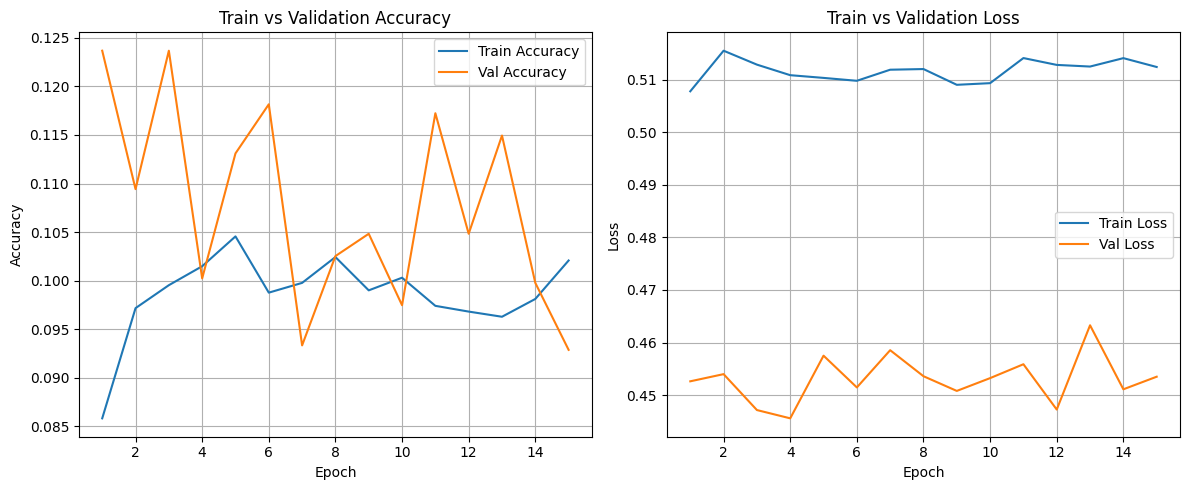

In [12]:
plot_training_curves(train_acc, val_acc, train_loss, val_loss)

In [ ]:
class VGG16MultiLabel(nn.Module):
    def __init__(self, num_classes=28):
        super(VGG16MultiLabel, self).__init__()
        vgg = models.vgg16(pretrained=True)
        for param in vgg.features.parameters():
            param.requires_grad = False  # freeze feature extractor

        self.features = vgg.features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 4, 2056),  # Adjust for 200x150 input
            nn.ReLU(),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16MultiLabel(num_classes=9).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

def compute_metrics(outputs, targets, threshold=0.4):
    outputs = outputs.detach().cpu().numpy()
    targets = targets.cpu().numpy()
    preds = (outputs >= threshold).astype(int)
    f1 = sklearn.metrics.f1_score(targets, preds, average='micro', zero_division=0)
    return f1

epochs = 50
best_f1 = 0.0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_outputs, val_targets = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs_prob = nn.Sigmoid(outputs)
            val_outputs.append(outputs_prob)
            val_targets.append(labels)

    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)
    val_f1 = compute_metrics(val_outputs, val_targets)
    print(f"Val F1 Score: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "vgg16_genre_model.pth")
        print(f"Saved best model with F1: {best_f1:.4f}")


Epoch 1:  23%|██▎       | 124/529 [05:38<18:25,  2.73s/it]


KeyboardInterrupt: 

We trained VGG16 model too, but by mistake I ran it again. It takes nearly 4-5hrs to train. So, I didnt run it again as I had its weights already.